In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowdflower-search-relevance/train.csv.zip
/kaggle/input/crowdflower-search-relevance/sampleSubmission.csv.zip
/kaggle/input/crowdflower-search-relevance/test.csv.zip


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


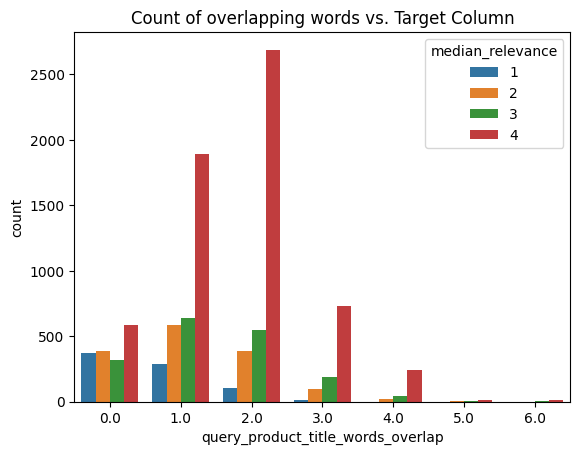

In [ ]:
import os
import wandb
from wandb.keras import WandbCallback
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
training = pd.read_csv('/kaggle/input/crowdflower-search-relevance/train.csv.zip')
stay_training = training
test = pd.read_csv('/kaggle/input/crowdflower-search-relevance/test.csv.zip')
test['relevance_variance'] = np.NaN
training['train_test'] = 1
#### I cant fill missing product desc with the average like I usually do
training.product_description.fillna('',inplace=True)
###
#training = training.drop(['product_description'], axis=1)
test['train_test'] = 0
all_data = pd.concat([training,test]) 


training['query_product_title_words_overlap'] = np.zeros(training.shape[0])

# Iterate through each row and count the overlapping words
for index, row in training.iterrows():
    query_text = row['query'].lower().split()
    product_title = row['product_title'].lower().split()
    count_overlap = sum(word in product_title for word in query_text)
    training.at[index, 'query_product_title_words_overlap'] = count_overlap

# Visualize the distribution
sns.countplot(data=training, x='query_product_title_words_overlap', hue='median_relevance')
plt.title('Count of overlapping words vs. Target Column')
plt.show()


#print(training.head())
#print(test.head())
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['median_relevance'], axis=1)
X_backup = X_train
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].median_relevance
y_check = y_train
y_backup = y_train
X_test = X_test.drop(['median_relevance'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

Feature Engineering

In [ ]:
x = stay_training.median_relevance.value_counts().keys()
y = stay_training.median_relevance.value_counts()


ax = stay_training.median_relevance.value_counts().plot(kind='bar',color=['C0', 'C1', 'C2','C3'])
for i,j in zip(x,y):
    plt.annotate(str(round(j/stay_training.shape[0]*100,2))+'%', xy=(i,j), ha='center', va='bottom')
plt.title('Bar plot of the target values')
plt.xlabel('Target values')
plt.show()

In [ ]:
y = stay_training['query'].value_counts().tolist()
y  = sorted(y,reverse=True)
x = range(len(y))
plt.bar(x,y)
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Bar plot of the query text categories and the count')
plt.show()

We can see that the data is very skewed, most queries appear only once and a lot of search results seem accurate.

I noticed in the data that some queries are essentially the same but differ in a blank space or a dash so I will put those together using editing distance. I excluded numbers causing this editing distance such that different "versions" of a product remain sepperate like playstation 3 and 4.
Unfortunately this was not possible right now due to long computation time.

In [ ]:
'''!pip install editdistance
import editdistance

def merge_similar_attributes(X_train):
    merged_df = X_train.copy()
    attribute_names = X_train.columns.tolist()
    merged_attributes = {}
    for i, attr1 in enumerate(attribute_names):
        for j, attr2 in enumerate(attribute_names[i+1:]):
            distance = editdistance.eval(attr1, attr2)
            if distance == 1 and not any(c.isdigit() for c in set(attr1).symmetric_difference(attr2)):
                merged_name = f"{attr1}_{attr2}"
                merged_df[merged_name] = X_train[attr1] + X_train[attr2]
                merged_attributes[merged_name] = (attr1, attr2)

    return merged_df, merged_attributes

X_train, merged_attributes_dict = merge_similar_attributes(X_train)'''

My next thought was that the same word appearing in both querry and product should have an impact

In [ ]:
stay_training['query_product_title_words_overlap'] = np.zeros(stay_training.shape[0])
for index, query_text in enumerate(stay_training['query']):
    count = 0
    query_text = query_text.lower().split()
    product_title = stay_training.product_title[index].lower() 
    for word in query_text:
        if word in product_title:
            count+=1

    stay_training.loc[index,'query_product_title_words_overlap'] = count
    
sns.countplot(data = stay_training, x = 'query_product_title_words_overlap', hue='median_relevance')
plt.title('Count of words from query that are in  product title')
plt.show()

This turned out to be true so Im adding a feature to reflect this (above due to X_train already being edited)

In [ ]:
print(training)

In [ ]:
print(test)

In [ ]:
import matplotlib.pyplot as plt

target_variable = 'median_relevance'
numeric_data = training.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[[target_variable]], annot=True, cmap='coolwarm', linewidths=.5)

plt.title(f'Correlation Heatmap with {target_variable}')
plt.show()

#due to the lack of numerical values, these types of visualization provide little information

In [ ]:
'''target_variable = 'relevance_variance'
correlations = X_train.corr()[target_column]
correlations = correlations.drop(target_variable)
# Filter features with a correlation of at least 0.4 or -0.4
significant_features = correlations[(correlations >= 0.1) | (correlations <= -0.1)]
significant_features_index = correlations[(correlations >= 0.1) | (correlations <= -0.1)].index
print(significant_features)
print(significant_features_index)

plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features.values, y=significant_features.index)
plt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()'''

In [ ]:
all_train = pd.concat([X_train, y_train], axis=1)

def create_splits(X_train, y_train, num_splits):
    total_features = X_train.shape[1]
    features_per_subset = total_features // num_splits
    all_train_splits = []
    for i in range(num_splits):
        start_idx = i * features_per_subset
        end_idx = (i + 1) * features_per_subset if i < num_splits - 1 else total_features
        subset_features = X_train.iloc[:, start_idx:end_idx]
        all_train_subset = pd.concat([subset_features, y_train], axis=1)
        all_train_splits.append(all_train_subset)

    return all_train_splits

num_splits = 3500
all_train_splits = create_splits(X_train, y_train, num_splits)


#print(all_train_splits[0].head())
plt.figure(figsize=(16, 8))
correlations = {}

from scipy.stats import pearsonr

def feature_stats(dataset, targ, correlation_threshold=0.05):
    features = dataset.drop(columns=[targ])
    target = dataset[targ]
    correlation_results = [pearsonr(features[feature], target) for feature in features.columns]
    selected_positive = [(feature, corr, p) for (feature, (corr, p)) in zip(features.columns, correlation_results) if corr >= correlation_threshold]
    selected_negative = [(feature, corr, p) for (feature, (corr, p)) in zip(features.columns, correlation_results) if corr <= -correlation_threshold]

    # Create a DataFrame to store the results
    stats_df = pd.DataFrame({
        'Feature': [item[0] for item in selected_positive + selected_negative],
        'Correlation': [item[1] for item in selected_positive + selected_negative],
        'P-Value': [item[2] for item in selected_positive + selected_negative],
    })

    return stats_df

stats_all_train_splits_0 = feature_stats(all_train_splits[0], 'median_relevance')
print('###############')
print(stats_all_train_splits_0)
print('###############')


def plot_feature_heatmap(dataset, targ, correlation_threshold=0.05):
    # Extract features and target
    features = dataset.drop(columns=[targ])  
    target = dataset[targ]
    feature_correlation = features.corrwith(target)
    selected_features = feature_correlation[(feature_correlation >= correlation_threshold) | (feature_correlation <= -correlation_threshold)]

    # Create a DataFrame to store the results
    corr_df = pd.DataFrame({'Correlation': selected_features})
    feature_correlation_list = list(zip(selected_features.index, selected_features.values))
    for feature, correlation in feature_correlation_list:
        print(f"{feature}: {correlation}")
    if not corr_df.empty:
        plt.figure(figsize=(50, 20))
        sns.heatmap(corr_df.transpose(), annot=True, cmap='coolwarm', linewidths=.5)
        plt.title('Feature Correlation Heatmap')
        plt.show()
    #else:
        #print("No features meet the correlation threshold criteria.")

    return feature_correlation_list

#plot_feature_heatmap(all_train_splits[0], 'relevance_variance')
def plot_clustered_heatmap(dataset, targ):
    features = dataset.drop(columns=[targ])  
    target = dataset[targ]
    feature_correlation = features.corrwith(target, method='spearman')
    corr_df = pd.DataFrame({'Correlation': feature_correlation})
    plt.figure(figsize=(20, 10))
    sns.clustermap(features.corr(method='spearman'), cmap='coolwarm', annot=True, linewidths=.5)
    plt.title('Clustered Feature Correlation Heatmap')
    plt.show()



In [ ]:
for i in range(3500):
    #print('###############')
    #here: 
    plot_feature_heatmap(all_train_splits[i], 'median_relevance')
    #plot_clustered_heatmap(all_train_splits[i], 'median_relevance')
    #stats_all_train_splits_0 = feature_stats(all_train_splits[i], 'relevance_variance')
    #print(stats_all_train_splits_0)
    #print('###############')

In [ ]:
#plot_significance(all_train_1, all_train_1['relevance_variance'], 'Split 1')

In [ ]:
attribute_names = training.columns.tolist()
print(attribute_names)

First attempt at Models

In [ ]:
X_backup = X_train
X_train_sig = X_train
num_samples = int(len(X_train) * 0.07)
random_indices = np.random.choice(len(X_train), num_samples, replace=False)
X_subset = X_train.iloc[random_indices]
y_subset = y_train.iloc[random_indices]

num_samples = int(len(X_backup) * 0.07)
random_indices = np.random.choice(len(X_backup), num_samples, replace=False)
X_backup = X_backup.iloc[random_indices]
y_backup = y_backup.iloc[random_indices]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary backup sets
X_train_temp, X_backup, y_train_sig, y_backup = train_test_split(X_train_sig, y_train, test_size=0.2, random_state=1)

# Split the backup set into a new validation set
X_backup, X_val, y_backup, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

# Ensure that the indices are reset for each subset
X_train_sig = X_train_temp.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_backup = X_backup.reset_index(drop=True)
y_train = y_train_sig.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_backup = y_backup.reset_index(drop=True)
num_samples = int(len(X_train_sig) * 0.07)
random_indices = np.random.choice(len(X_train_sig), num_samples, replace=False)
X_subset = X_train_sig.iloc[random_indices]
y_subset = y_train.iloc[random_indices]

num_samples = int(len(X_backup) * 0.07)
random_indices = np.random.choice(len(X_backup), num_samples, replace=False)
X_backup = X_backup.iloc[random_indices]
y_backup = y_backup.iloc[random_indices]

In [ ]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Convert the current time to a string with a specific format
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Create a string with the formatted time
time = f"{formatted_time}"

In [ ]:
from sklearn.metrics import  accuracy_score, cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score,weights = 'quadratic', greater_is_better = True)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

wandb.init(project='CrowdflowerByHand', name='untuned attemps '+time)

def run_cross_validation(models, X_train, y_train, cv=5):
    results = []

    for model in models:
        model_name = model.__class__.__name__

        '''if model_name == 'XGBClassifier':
            class_counts = y_train.value_counts()
            class_weight = class_counts[0] / class_counts[1]
            model = XGBClassifier(scale_pos_weight=class_weight, random_state=1)'''
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
        
        # Log the results to WandB:
        wandb.log({f'{model_name}_CV_Scores': cv_scores.tolist(), f'{model_name}_Mean_CV_Score': np.mean(cv_scores)})
        
        results.append({
            'model_name': model_name,
            'cv_scores': cv_scores,
            'mean_cv_score': np.mean(cv_scores),
            #'parameters': {
                #'scale_pos_weight': class_weight if model_name == 'XGBClassifier' else None
            #}
        })

    return results

xgb = XGBClassifier(random_state =1)



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#model = []
models = [
    xgb,
    LinearSVC(),
    GaussianNB(),
    LogisticRegression(max_iter=2000),
    RandomForestClassifier(random_state=1),
    GradientBoostingClassifier(random_state=1),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(probability=True)
]
models_2 = []
for mod in models:
    mod_2 = GridSearchCV(mod, param_grid={},scoring=kappa_scorer)
    models_2.append(mod_2)
    
#print(models_2)
#results = run_cross_validation(models_2, X_subset, y_subset, cv=5)
#print(results)
'''svc = LinearSVC()
svc = GridSearchCV(LinearSVC(), param_grid={'C': [1, 10]},scoring=kappa_scorer)
cv = cross_val_score(svc,X_subset,y_subset,cv=5)'''
param_grid = {'svd__n_components' : [200, 400],
              'svm__C': [10, 12]}

svc = GridSearchCV(estimator = SVC(), param_grid={}, scoring=kappa_scorer,
                                  verbose=10, n_jobs=-1, refit=True, cv=5)
svc.fit(X_check, y_check)
print("Best score: %0.3f" % svc.best_score_)
#cv = cross_val_score(svc,X_subset,y_subset,cv=5)
#print(cv)
#print(cv.mean())

In [ ]:

wandb.finish()